In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# jax
from jax import numpy as jnp
# numpy
import numpy as np
import random
import matplotlib.pyplot as plt
# utils
from tqdm.notebook import tqdm
import pickle
# custom modules
from canvas import *
from placer import *
from box import *
from net import *
from neuroPlacer import *
from VAEPlacer import *

## Pseudo Testcase Generation

number of boxes: 100 100
number of nets: 225 225


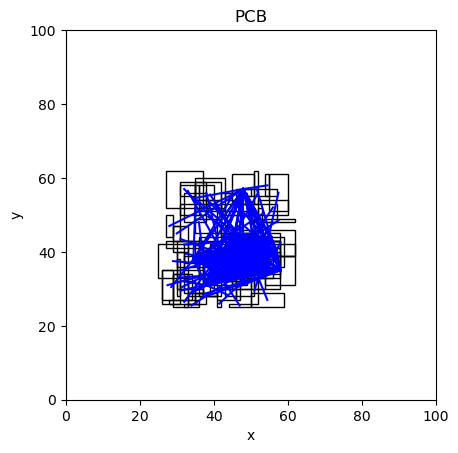

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [2]:
# make some boxes and nets
box_collection = {}
net_collection = {}

num_boxes = 100
num_nets = 15

# the first box of each net is the source box
source_box_collection = []

# generate 10 boxes and 3 nets
for i in range(0, num_boxes):
    net_idx = int(i % num_nets)
    box_collection[f"box_{i}"] = Box(
        box_name=f"box_{i}",
        llx=random.randint(25, 55),
        lly=random.randint(25, 55),
        width=random.randint(1, 10),
        height=random.randint(1, 10),
        net_name_list=[f"net_{net_idx}"],
    )

    if f"net_{net_idx}" not in net_collection:
        net_collection[f"net_{net_idx}"] = Net(
            net_name=f"net_{net_idx}", source_box_name=f"box_{i}", sink_box_names=[]
        )
        source_box_collection.append(f"box_{i}")
    else:
        net_collection[f"net_{net_idx}"].add_sink_box_name(f"box_{i}")
        
ADD_PAIRWISE_CONNECTIONS = True
if ADD_PAIRWISE_CONNECTIONS:
    net_idx = num_nets + 1
    # connect all the source boxes to each other
    for source_box_name in source_box_collection:
        for other_source_box_name in source_box_collection:
            if source_box_name != other_source_box_name:
                # create a new net
                net_collection[f"net_{net_idx}"] = Net(
                    net_name=f"net_{net_idx}", source_box_name=source_box_name, sink_box_names=[]
                )
                # add the other source box as a sink
                net_collection[f"net_{net_idx}"].add_sink_box_name(other_source_box_name)
                # add the net to the source box / other source box
                box_collection[source_box_name].add_net_name(f"net_{net_idx}")
                box_collection[other_source_box_name].add_net_name(f"net_{net_idx}")
                # increment the net index
                net_idx += 1

ADD_SUPER_CONNECTION = False
if ADD_SUPER_CONNECTION:
    net_idx = num_nets + num_boxes
    # connect all the source box to a super net
    net_collection[f"net_{net_idx}"] = Net(
        net_name=f"net_{net_idx}", source_box_name=source_box_collection[0], sink_box_names=[]
    )
    # add the net to the source box
    box_collection[source_box_collection[0]].add_net_name(f"net_{net_idx}")

    for source_box_name in source_box_collection:
        if source_box_name != source_box_collection[0]:
            net_collection[f"net_{net_idx}"].add_sink_box_name(source_box_name)
            box_collection[source_box_name].add_net_name(f"net_{net_idx}")


# make a canvas
pcb_canvas = PCBCanvas(width=100, height=100, boxes=box_collection, nets=net_collection)
print("number of boxes:", len(pcb_canvas.boxes), len(box_collection))
# for box in pcb_canvas.boxes.values():
#     print(box)
print("number of nets:", len(pcb_canvas.nets), len(net_collection))
# for net in pcb_canvas.nets.values():
#     print(net.net_name, net.source_box_name, net.box_names)

pcb_canvas.plot()

print(pcb_canvas.get_incidence_matrix())

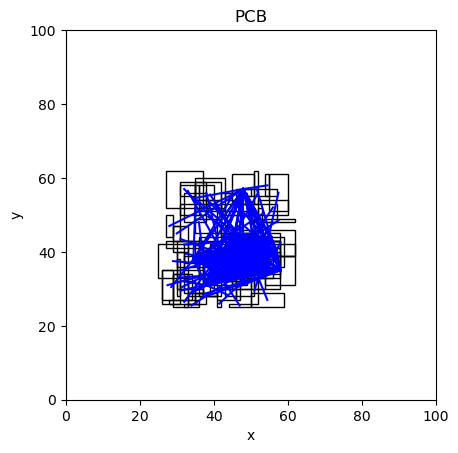

wirelength:	 3872.7148678411863


In [3]:
# pickle the canvas
pickle_id = '10_pair'
# with open(f"./testcase/pcb_canvas_{pickle_id}.pkl", "wb") as f:
#     pickle.dump(pcb_canvas, f)
# load the canvas
with open(f"./testcase/pcb_canvas_{pickle_id}.pkl", "rb") as f:
    pcb_canvas = pickle.load(f)

pcb_canvas.plot()
print("wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())

In [4]:
for net in pcb_canvas.nets.values():
    print(net.net_name, net.source_box_name, net.box_names)

net_0 box_0 ['box_0', 'box_15', 'box_30', 'box_45', 'box_60', 'box_75', 'box_90']
net_1 box_1 ['box_1', 'box_16', 'box_31', 'box_46', 'box_61', 'box_76', 'box_91']
net_2 box_2 ['box_2', 'box_17', 'box_32', 'box_47', 'box_62', 'box_77', 'box_92']
net_3 box_3 ['box_3', 'box_18', 'box_33', 'box_48', 'box_63', 'box_78', 'box_93']
net_4 box_4 ['box_4', 'box_19', 'box_34', 'box_49', 'box_64', 'box_79', 'box_94']
net_5 box_5 ['box_5', 'box_20', 'box_35', 'box_50', 'box_65', 'box_80', 'box_95']
net_6 box_6 ['box_6', 'box_21', 'box_36', 'box_51', 'box_66', 'box_81', 'box_96']
net_7 box_7 ['box_7', 'box_22', 'box_37', 'box_52', 'box_67', 'box_82', 'box_97']
net_8 box_8 ['box_8', 'box_23', 'box_38', 'box_53', 'box_68', 'box_83', 'box_98']
net_9 box_9 ['box_9', 'box_24', 'box_39', 'box_54', 'box_69', 'box_84', 'box_99']
net_10 box_10 ['box_10', 'box_25', 'box_40', 'box_55', 'box_70', 'box_85']
net_11 box_11 ['box_11', 'box_26', 'box_41', 'box_56', 'box_71', 'box_86']
net_12 box_12 ['box_12', 'box_

In [5]:
# extract the current canvas dimension
canvas_width = pcb_canvas.width
canvas_height = pcb_canvas.height
# canvas dimension (maxX, maxY, minX, minY)
canvas_dim = pcb_canvas.get_canvas_dim()
maxX, maxY, minX, minY = canvas_dim
compx = pcb_canvas.get_cxy()[:, 0]
compx_jnp = jnp.array(compx)

compy = pcb_canvas.get_cxy()[:, 1]
compy_jnp = jnp.array(compy)

comph = pcb_canvas.get_all_boxes_width()
comph_jnp = jnp.array(comph)

compw = pcb_canvas.get_all_boxes_height()
compw_jnp = jnp.array(compw)

num_bin_x = 10
num_bin_y = 10

# [Net to pin coord] mapping 
net_to_pin_coords = {}
for net in pcb_canvas.nets.values():
    print(net.net_name, net.box_names)
    for box_name in net.box_names:
        if net.net_name not in net_to_pin_coords:
            net_to_pin_coords[net.net_name] = [pcb_canvas.get_box_cxy(box_name)]
        else:
            net_to_pin_coords[net.net_name].append(pcb_canvas.get_box_cxy(box_name))

print("net to pin coords:")
for net, pin_coords in net_to_pin_coords.items():
    print(net, pin_coords)

# [Net to pin coord] mapping
net_to_insts = {}
for net in pcb_canvas.nets.values():
    net_to_insts[net.net_name] = net.box_names

print("net to insts:")
for net, insts in net_to_insts.items():
    print(net, insts)


net_0 ['box_0', 'box_15', 'box_30', 'box_45', 'box_60', 'box_75', 'box_90']
net_1 ['box_1', 'box_16', 'box_31', 'box_46', 'box_61', 'box_76', 'box_91']
net_2 ['box_2', 'box_17', 'box_32', 'box_47', 'box_62', 'box_77', 'box_92']
net_3 ['box_3', 'box_18', 'box_33', 'box_48', 'box_63', 'box_78', 'box_93']
net_4 ['box_4', 'box_19', 'box_34', 'box_49', 'box_64', 'box_79', 'box_94']
net_5 ['box_5', 'box_20', 'box_35', 'box_50', 'box_65', 'box_80', 'box_95']
net_6 ['box_6', 'box_21', 'box_36', 'box_51', 'box_66', 'box_81', 'box_96']
net_7 ['box_7', 'box_22', 'box_37', 'box_52', 'box_67', 'box_82', 'box_97']
net_8 ['box_8', 'box_23', 'box_38', 'box_53', 'box_68', 'box_83', 'box_98']
net_9 ['box_9', 'box_24', 'box_39', 'box_54', 'box_69', 'box_84', 'box_99']
net_10 ['box_10', 'box_25', 'box_40', 'box_55', 'box_70', 'box_85']
net_11 ['box_11', 'box_26', 'box_41', 'box_56', 'box_71', 'box_86']
net_12 ['box_12', 'box_27', 'box_42', 'box_57', 'box_72', 'box_87']
net_13 ['box_13', 'box_28', 'box_43'

# Placement Stage

wirelength:	 3872.7148678411863


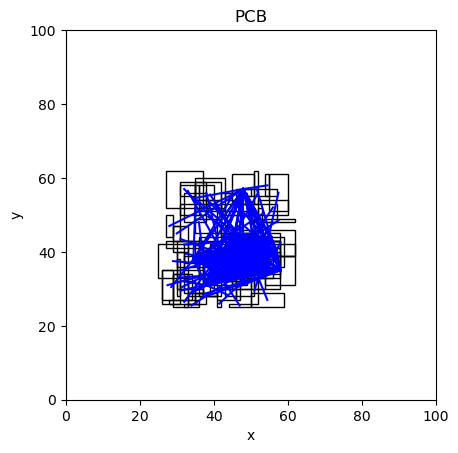

****************************************************
Weighted-average wirelength_2 grad:
 {'box_0': Array([-6.578307 , -1.6780057], dtype=float32), 'box_15': Array([ 0.1494394 , -0.22798812], dtype=float32), 'box_30': Array([0.29556006, 0.00999981], dtype=float32), 'box_45': Array([0.16918463, 0.371049  ], dtype=float32), 'box_60': Array([ 0.24742007, -0.02999544], dtype=float32), 'box_75': Array([0.3523726 , 0.22798806], dtype=float32), 'box_90': Array([0.01999873, 0.08987868], dtype=float32), 'box_1': Array([-3.2887123, -4.8725643], dtype=float32), 'box_16': Array([-0.10977861,  0.444278  ], dtype=float32), 'box_31': Array([0.24742001, 0.37104893], dtype=float32), 'box_46': Array([0.00999978, 0.01999873], dtype=float32), 'box_61': Array([0.04997915, 0.22798824], dtype=float32), 'box_76': Array([0.15931994, 0.17903268], dtype=float32), 'box_91': Array([-0.05996409,  0.01999873], dtype=float32), 'box_2': Array([-1.362472 ,  3.5050406], dtype=float32), 'box_17': Array([0.12963486, 0.227

In [6]:
# make a placer
pcbplacer = PCBPlacer(pcb_canvas)
pin_grad_to_inst = {} # aggregate the pin gradients for each instance

# init placement
# pcbplacer.init_plc_spectral()
print("wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())
pcb_canvas.plot()
WA_sum = 0
#### WA objective for each net
print("****************************************************")
print("Weighted-average wirelength_2 grad:\n", pcbplacer.Wa_obj_grad(
    net_to_pin_coords=net_to_pin_coords,
    net_to_insts=net_to_insts, SMOOTHNESS = 50))

print("HPWL objective grad: \n", pcbplacer.HPWL_obj_grad( net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts, verbose=False))


#### Density objective
print("****************************************************")
# print("Weighted-average wirelength_2:\n", pcbplacer.wirelength_objective_fn(
#     net_to_pin_coords=net_to_pin_coords,
#     net_to_insts=net_to_insts))
# print("Weighted-average wirelength_2 grad:\n", pcbplacer.wirelength_objective_fn_grad_jax(
#     net_to_pin_coords=net_to_pin_coords,
#     net_to_insts=net_to_insts, verbose=False))
print("Density objective: \n", pcbplacer.Grid_density_obj(
    compx_=compx,
    compy_=compy,
    compw_=compw,
    comph_=comph,
    canvas_dims=canvas_dim,
    num_bin_x=10,
    num_bin_y=10,
))

print("compx: ", compx)
print("compy: ", compy)
print("Density objective grad: \n", pcbplacer.Grid_density_obj_grad(
    compx_=compx_jnp,
    compy_=compy_jnp,
    compw_=compw_jnp,
    comph_=comph_jnp,
    canvas_dims=canvas_dim,
    num_bin_x=10,
    num_bin_y=10,
    verbose=True,
))

In [7]:
%%script false --no-raise-error
print("Before wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())
print(
    "Before density:\t",
    pcbplacer.Grid_density_obj(
        compx_=compx,
        compy_=compy,
        compw_=compw,
        comph_=comph,
        canvas_dims=canvas_dim,
        num_bin_x=10,
        num_bin_y=10,
    ),
)

# clear the plot folder
for f in os.listdir("./plot/grad_density/"):
    os.remove(os.path.join("./plot/grad_density/", f))

# iteratively update the placement with only density objective
for i in tqdm(range(0, 100)):
    # plot the canvas
    pcb_canvas.plot(savefig=True, filename=f"./plot/grad_density/placement_{i}.png")

    # compute the gradient
    density_grad = pcbplacer.Grid_density_obj_grad(
        compx_=compx,
        compy_=compy,
        compw_=compw,
        comph_=comph,
        canvas_dims=canvas_dim,
        num_bin_x=10,
        num_bin_y=10,
        verbose=False,
    )

    # update the placement
    for grad in density_grad.keys():
        cx, cy = pcb_canvas.get_box_cxy(grad)
        if_move_x, if_move_y = pcbplacer.check_boundary(
            cx,
            cy,
            pcb_canvas.get_box_width(grad),
            pcb_canvas.get_box_height(grad),
            100 * density_grad[grad][0],
            100 * density_grad[grad][1],
            minX,
            minY,
            maxX,
            maxY,
        )

        if if_move_x:
            cx -= 100 * density_grad[grad][0]
        if if_move_y:
            cy -= 100 * density_grad[grad][1]

        pcb_canvas.set_box_cxy(grad, cx, cy)

    # update net_to_pin_coords
    compx = pcb_canvas.get_cxy()[:, 0]
    compy = pcb_canvas.get_cxy()[:, 1]

print("After wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())
print(
    "After density:\t",
    pcbplacer.Grid_density_obj(
        compx_=compx,
        compy_=compy,
        compw_=compw,
        comph_=comph,
        canvas_dims=canvas_dim,
        num_bin_x=10,
        num_bin_y=10,
    ),
)

# generate the placement gif
pcb_canvas.generate_gif_from_plots("grad_density", "placement_density_grad.gif")

In [8]:
%%script false --no-raise-error
# print the wirelength
print("Before wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())
# clear the plot folder
for f in os.listdir("./plot/grad_HPWL/"):
    os.remove(os.path.join("./plot/grad_HPWL/", f))

# iterate only with Wa_obj_grad and update the location of the instances
for i in tqdm(range(0, 10)):
    # plot the canvas
    pcb_canvas.plot(savefig=True, filename=f"./plot/grad_HPWL/placement_{i}.png")

    # compute the gradient
    HPWL_grad = pcbplacer.HPWL_obj_grad(
        net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts
    )

    # print("HPWL_grad length:", len(HPWL_grad))
    for grad in HPWL_grad.keys():
        cx, cy = pcb_canvas.get_box_cxy(grad)
        pcb_canvas.set_box_cxy(
            grad, cx - 0.1 * HPWL_grad[grad][0], cy - 0.1 * HPWL_grad[grad][1]
        )

    # update net_to_pin_coords
    net_to_pin_coords = {}
    for net in pcb_canvas.nets.values():
        # print(net.net_name)
        for box_name in net.box_names:
            # print(box_name)
            if net.net_name not in net_to_pin_coords:
                net_to_pin_coords[net.net_name] = [pcb_canvas.get_box_cxy(box_name)]
            else:
                net_to_pin_coords[net.net_name].append(pcb_canvas.get_box_cxy(box_name))

    # print(net_to_pin_coords)

# print the wirelength
print("After wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())

pcb_canvas.generate_gif_from_plots("grad_HPWL", "placement_HPWL_grad.gif")

In [9]:
%%script false --no-raise-error
# print the wirelength
print("Before wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())
# clear the plot folder
for f in os.listdir("./plot/grad_Wa/"):
    os.remove(os.path.join("./plot/grad_Wa/", f))

# iterate only with Wa_obj_grad and update the location of the instances
for i in tqdm(range(0, 10)):
    # plot the canvas
    pcb_canvas.plot(savefig=True, filename=f"./plot/grad_Wa/placement_{i}.png")

    # compute the gradient
    Wa_obj_grad = pcbplacer.Wa_obj_grad(
        net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts, SMOOTHNESS = 50
    )

    for grad in Wa_obj_grad.keys():
        print(grad, Wa_obj_grad[grad])
        cx, cy = pcb_canvas.get_box_cxy(grad)
        pcb_canvas.set_box_cxy(
            grad, cx -  Wa_obj_grad[grad][0], cy -  Wa_obj_grad[grad][1]
        )

    # update net_to_pin_coords
    net_to_pin_coords = {}
    for net in pcb_canvas.nets.values():
        # print(net.net_name)
        for box_name in net.box_names:
            # print(box_name)
            if net.net_name not in net_to_pin_coords:
                net_to_pin_coords[net.net_name] = [pcb_canvas.get_box_cxy(box_name)]
            else:
                net_to_pin_coords[net.net_name].append(pcb_canvas.get_box_cxy(box_name))

    print(net_to_pin_coords)

# print the wirelength
print("After wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())

pcb_canvas.generate_gif_from_plots("grad_Wa", "placement_Wa_grad.gif")

## Gradient-based Placement 

In [10]:
# %%script false --no-raise-error
# pcbplacer.init_plc_spectral()
print("wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())
lambda_Density = 0.01
# print the wirelength
print("Before wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())

if not os.path.exists(f"./plot/grad_{pickle_id}/"):
    os.makedirs(f"./plot/grad_{pickle_id}/")
# clear the plot folder
for f in os.listdir(f"./plot/grad_{pickle_id}/"):
    os.remove(os.path.join(f"./plot/grad_{pickle_id}/", f))

prev_Wa_obj = pcbplacer.Wa_obj(
    net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts, SMOOTHNESS=50
)
prev_Density_obj = pcbplacer.Density_obj(
    compx_=compx,
    compy_=compy,
    compw_=compw,
    comph_=comph,
    canvas_dims=canvas_dim,
    num_bin_x=10,
    num_bin_y=10,
)

# iterate only with Wa_obj_grad & Density_obj_grad and update the location of the instances
for i in tqdm(range(0, 500)):
    # plot the canvas
    pcb_canvas.plot(savefig=True, filename=f"./plot/grad_{pickle_id}/placement_{i}.png")

    # compute the gradient
    Wa_obj_grad = pcbplacer.Wa_obj_grad(
        net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts, SMOOTHNESS=50
    )
    Density_obj_grad = pcbplacer.Density_obj_grad(
        compx_=compx,
        compy_=compy,
        compw_=compw,
        comph_=comph,
        canvas_dims=canvas_dim,
        num_bin_x=10,
        num_bin_y=10,
        verbose=False,
    )

    # if nan density gradient, then set to 0
    for grad in Density_obj_grad.keys():
        if np.isnan(Density_obj_grad[grad][0]) or np.isnan(Density_obj_grad[grad][1]):
            Density_obj_grad[grad] = np.array([1e6, 1e6])

    # compute the gradient
    for Wa_grad, Density_grad in zip(Wa_obj_grad.keys(), Density_obj_grad.keys()):
        # print(grad, Wa_obj_grad[grad])
        cx, cy = pcb_canvas.get_box_cxy(Wa_grad)
        # dynamically scale the lambda_Density based on the scale of the Wa_obj_grad
        # lambda_Density = np.linalg.norm(Wa_obj_grad[Wa_grad]) / np.linalg.norm(Density_obj_grad[Density_grad])

        total_grad = -1 * (
            Wa_obj_grad[Wa_grad] + lambda_Density * Density_obj_grad[Density_grad]
        )

        if_move_x, if_move_y = pcbplacer.check_boundary(
            cx,
            cy,
            pcb_canvas.get_box_width(Wa_grad),
            pcb_canvas.get_box_height(Wa_grad),
            total_grad[0],
            total_grad[1],
            minX,
            minY,
            maxX,
            maxY,
        )
        # print(f"    [INFO] total_grad: {total_grad}, wa_grad: {Wa_obj_grad[Wa_grad]}, density_grad: {lambda_Density * Density_obj_grad[Density_grad]}")

        if if_move_x:
            cx += total_grad[0]
        if if_move_y:
            cy += total_grad[1]

        pcb_canvas.set_box_cxy(Wa_grad, cx, cy)

    # update net_to_pin_coords
    net_to_pin_coords = {}
    for net in pcb_canvas.nets.values():
        # print(net.net_name)
        for box_name in net.box_names:
            # print(box_name)
            if net.net_name not in net_to_pin_coords:
                net_to_pin_coords[net.net_name] = [pcb_canvas.get_box_cxy(box_name)]
            else:
                net_to_pin_coords[net.net_name].append(pcb_canvas.get_box_cxy(box_name))
    
    #update compx, compy
    compx = pcb_canvas.get_cxy()[:, 0]
    compy = pcb_canvas.get_cxy()[:, 1]

    # reevaluate the density objective
    Density_obj = pcbplacer.Density_obj(
        compx_=compx,
        compy_=compy,
        compw_=compw,
        comph_=comph,
        canvas_dims=canvas_dim,
        num_bin_x=10,
        num_bin_y=10,
    )

    # reevaluate the wirelength objective
    Wa_obj = pcbplacer.wirelength_objective_fn(
        net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts
    )

    print(f"    [INFO] Wa_obj: {Wa_obj}, Density_obj: {Density_obj}")

    # check the convergence
    if (
        abs(prev_Wa_obj - Wa_obj) < 100
        and abs(prev_Density_obj - Density_obj) < 100
    ):
        print("Converged!")
        break

    prev_Wa_obj = Wa_obj
    prev_Density_obj = Density_obj

    # print(net_to_pin_coords)

# print the wirelength
print("After wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())

pcb_canvas.generate_gif_from_plots(f"grad_{pickle_id}", f"placement_{pickle_id}_grad.gif")

wirelength:	 3872.7148678411863
Before wirelength:	 3872.7148678411863


/tmp/ipykernel_720257/4034436792.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(0, 500)):


  0%|          | 0/500 [00:00<?, ?it/s]

    [INFO] Wa_obj: 10237.563478619128, Density_obj: 390151.3125
    [INFO] Wa_obj: 8923.346363574266, Density_obj: 384775.9375
    [INFO] Wa_obj: 10000.788410842419, Density_obj: 365052.3125
    [INFO] Wa_obj: 11524.428755581379, Density_obj: 305710.78125
    [INFO] Wa_obj: 10597.374358862638, Density_obj: 325041.34375
    [INFO] Wa_obj: 12740.374892532825, Density_obj: 299184.96875
    [INFO] Wa_obj: 11780.880402684212, Density_obj: 289704.25
    [INFO] Wa_obj: 12564.259802281857, Density_obj: 258951.21875
    [INFO] Wa_obj: 12383.670239388943, Density_obj: 212626.453125
    [INFO] Wa_obj: 11599.517655968666, Density_obj: 208904.765625
    [INFO] Wa_obj: 11830.105633497238, Density_obj: 199553.578125
    [INFO] Wa_obj: 11529.022251278162, Density_obj: 194881.0625
    [INFO] Wa_obj: 12064.049511492252, Density_obj: 179929.03125
    [INFO] Wa_obj: 12506.424378752708, Density_obj: 183538.265625
    [INFO] Wa_obj: 12774.60800242424, Density_obj: 177823.4375
    [INFO] Wa_obj: 12735.316164

In [11]:
print("After wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())
print("After total overlap:\t", pcb_canvas.total_overlapping_area())
pcb_canvas.generate_gif_from_plots(f"grad_{pickle_id}", f"placement_{pickle_id}_grad.gif")

After wirelength:	 4907.254838705063
After total overlap:	 2950.1091


In [12]:
# %%script false --no-raise-error
pcbplacer.init_plc_spectral()
print("wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())
lambda_Density = 0.01
# print the wirelength
print("Before wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())

if not os.path.exists(f"./plot/grad_{pickle_id}/"):
    os.makedirs(f"./plot/grad_{pickle_id}/")
# clear the plot folder
for f in os.listdir(f"./plot/grad_{pickle_id}/"):
    os.remove(os.path.join(f"./plot/grad_{pickle_id}/", f))

prev_Wa_obj = pcbplacer.Wa_obj(
    net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts, SMOOTHNESS=50
)
prev_Density_obj = pcbplacer.Density_obj(
    compx_=compx,
    compy_=compy,
    compw_=compw,
    comph_=comph,
    canvas_dims=canvas_dim,
    num_bin_x=10,
    num_bin_y=10,
)

# iterate only with Wa_obj_grad & Density_obj_grad and update the location of the instances
for i in tqdm(range(0, 500)):
    # plot the canvas
    pcb_canvas.plot(savefig=True, filename=f"./plot/grad_{pickle_id}/placement_{i}.png")

    # compute the gradient
    Wa_obj_grad = pcbplacer.Wa_obj_grad(
        net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts, SMOOTHNESS=50
    )
    Density_obj_grad = pcbplacer.Density_obj_grad(
        compx_=compx,
        compy_=compy,
        compw_=compw,
        comph_=comph,
        canvas_dims=canvas_dim,
        num_bin_x=10,
        num_bin_y=10,
        verbose=False,
    )

    # if nan density gradient, then set to 0
    for grad in Density_obj_grad.keys():
        if np.isnan(Density_obj_grad[grad][0]) or np.isnan(Density_obj_grad[grad][1]):
            Density_obj_grad[grad] = np.array([1e6, 1e6])

    # compute the gradient
    for Wa_grad, Density_grad in zip(Wa_obj_grad.keys(), Density_obj_grad.keys()):
        # print(grad, Wa_obj_grad[grad])
        cx, cy = pcb_canvas.get_box_cxy(Wa_grad)
        # dynamically scale the lambda_Density based on the scale of the Wa_obj_grad
        # lambda_Density = np.linalg.norm(Wa_obj_grad[Wa_grad]) / np.linalg.norm(Density_obj_grad[Density_grad])

        total_grad = -1 * (
            Wa_obj_grad[Wa_grad] + lambda_Density * Density_obj_grad[Density_grad]
        )

        if_move_x, if_move_y = pcbplacer.check_boundary(
            cx,
            cy,
            pcb_canvas.get_box_width(Wa_grad),
            pcb_canvas.get_box_height(Wa_grad),
            total_grad[0],
            total_grad[1],
            minX,
            minY,
            maxX,
            maxY,
        )
        # print(f"    [INFO] total_grad: {total_grad}, wa_grad: {Wa_obj_grad[Wa_grad]}, density_grad: {lambda_Density * Density_obj_grad[Density_grad]}")

        if if_move_x:
            cx += total_grad[0]
        if if_move_y:
            cy += total_grad[1]

        pcb_canvas.set_box_cxy(Wa_grad, cx, cy)

    # update net_to_pin_coords
    net_to_pin_coords = {}
    for net in pcb_canvas.nets.values():
        # print(net.net_name)
        for box_name in net.box_names:
            # print(box_name)
            if net.net_name not in net_to_pin_coords:
                net_to_pin_coords[net.net_name] = [pcb_canvas.get_box_cxy(box_name)]
            else:
                net_to_pin_coords[net.net_name].append(pcb_canvas.get_box_cxy(box_name))
    
    #update compx, compy
    compx = pcb_canvas.get_cxy()[:, 0]
    compy = pcb_canvas.get_cxy()[:, 1]

    # reevaluate the density objective
    Density_obj = pcbplacer.Density_obj(
        compx_=compx,
        compy_=compy,
        compw_=compw,
        comph_=comph,
        canvas_dims=canvas_dim,
        num_bin_x=10,
        num_bin_y=10,
    )

    # reevaluate the wirelength objective
    Wa_obj = pcbplacer.wirelength_objective_fn(
        net_to_pin_coords=net_to_pin_coords, net_to_insts=net_to_insts
    )

    print(f"    [INFO] Wa_obj: {Wa_obj}, Density_obj: {Density_obj}")

    # check the convergence
    if (
        abs(prev_Wa_obj - Wa_obj) < 100
        and abs(prev_Density_obj - Density_obj) < 100
    ):
        print("Converged!")
        break

    prev_Wa_obj = Wa_obj
    prev_Density_obj = Density_obj

    # print(net_to_pin_coords)

# print the wirelength
print("After wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())

pcb_canvas.generate_gif_from_plots(f"grad_{pickle_id}", f"placement_{pickle_id}_grad_spec.gif")

wirelength:	 7704.590692479243
Before wirelength:	 7704.590692479243


/tmp/ipykernel_720257/2897819597.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(0, 500)):


  0%|          | 0/500 [00:00<?, ?it/s]

    [INFO] Wa_obj: 16853.874285370795, Density_obj: 269570.59375
    [INFO] Wa_obj: 15320.895685478054, Density_obj: 273253.25
    [INFO] Wa_obj: 14667.562847254247, Density_obj: 237367.34375
    [INFO] Wa_obj: 13942.530723207781, Density_obj: 241025.6875
    [INFO] Wa_obj: 14330.30543465049, Density_obj: 231219.1875
    [INFO] Wa_obj: 14477.520730382335, Density_obj: 238618.859375
    [INFO] Wa_obj: 14424.509039081544, Density_obj: 219334.40625
    [INFO] Wa_obj: 15578.565850648414, Density_obj: 179128.578125
    [INFO] Wa_obj: 14871.642717078264, Density_obj: 178258.3125
    [INFO] Wa_obj: 14674.616780475088, Density_obj: 176936.25
    [INFO] Wa_obj: 14066.59823203798, Density_obj: 181187.515625
    [INFO] Wa_obj: 14383.550022617046, Density_obj: 195387.90625
    [INFO] Wa_obj: 14621.6672750092, Density_obj: 188964.5
    [INFO] Wa_obj: 13648.043073045148, Density_obj: 181260.140625
    [INFO] Wa_obj: 13526.40138404666, Density_obj: 170827.40625
    [INFO] Wa_obj: 13075.906264056439, 

In [ ]:
print("After wirelength:\t", pcb_canvas.get_total_wirelength_from_cxy())
print("After total overlap:\t", pcb_canvas.total_overlapping_area())
pcb_canvas.generate_gif_from_plots(f"grad_{pickle_id}", f"placement_{pickle_id}_grad_spec.gif")